In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

In [89]:
# incl = ['DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS', 'PUF_CASE_ID']
data = pd.read_csv('data/data_os_clean_imputed.csv', index_col='PUF_CASE_ID')
y = data['3-yr Mortality']
X = data.drop(['3-yr Mortality'], axis=1)

In [90]:
y.value_counts()

0    25802
1     7988
Name: 3-yr Mortality, dtype: int64

In [91]:
models = ['rf']
hp_dfs = {}
for model in models:
    hp_dfs[model] = pd.read_csv('hp_search/results/results_' + model + '.csv')

rf_params = {'bootstrap': hp_dfs['rf']['param_bootstrap'].iloc[0],
            'max_depth': hp_dfs['rf']['param_max_depth'].iloc[0],
            'max_features': hp_dfs['rf']['param_max_features'].iloc[0],
            'min_samples_leaf': hp_dfs['rf']['param_min_samples_leaf'].iloc[0],
            'min_samples_split': hp_dfs['rf']['param_min_samples_split'].iloc[0],
            'n_estimators': hp_dfs['rf']['param_n_estimators'].iloc[0]}
#change nan to None
rf_params = {k: None if pd.isna(v) else v for k, v in rf_params.items()}
best_rf = RandomForestClassifier(**rf_params)
best_rf.fit(X, y)

RandomForestClassifier(max_depth=120.0, min_samples_leaf=8, min_samples_split=3,
                       n_estimators=750)

In [92]:
rf_preds = best_rf.predict_proba(X)[:, 1]
data['pred_os'] = rf_preds

In [93]:
data_km = pd.read_csv('data/data_km.csv', index_col='PUF_CASE_ID')
data_km.head()

,DX_LASTCONTACT_DEATH_MONTHS,PUF_VITAL_STATUS
PUF_CASE_ID,,
D66f458f9-bdc0-4c95-94a3-a5f8c5bb74f9,48.82,1.0
Dfc68ea23-71aa-4b0d-87c0-587b4ce13d04,65.64,0.0
D54a1d0da-4328-4ca5-8481-87cd73b33dd4,67.48,1.0
D62170955-5fc5-434e-8e6a-6a9e139851c4,37.19,1.0
D2cfdabba-8277-463e-bf64-7c3139b45372,15.47,1.0


In [94]:
data['DX_LASTCONTACT_DEATH_MONTHS'] = np.NaN
data['PUF_VITAL_STATUS'] = np.NaN
data.update(data_km)

In [95]:
data['DX_LASTCONTACT_DEATH_MONTHS'].describe()

count    33790.000000
mean        70.066366
std         45.868262
min          0.000000
25%         37.190000
50%         61.930000
75%         99.680000
max        208.790000
Name: DX_LASTCONTACT_DEATH_MONTHS, dtype: float64

In [109]:
incl = ['pred_os', 'DX_LASTCONTACT_DEATH_MONTHS', 'PUF_VITAL_STATUS']
data_km_pred = data[incl]
data_km_pred.shape

(33790, 3)

In [110]:
data_km_pred['pred_os'].describe()

count    33790.000000
mean         0.237167
std          0.168189
min          0.005165
25%          0.102735
50%          0.194335
75%          0.337232
max          0.893010
Name: pred_os, dtype: float64

In [111]:
#get the 33rd percentile
q_1 = round(data_km_pred['pred_os'].quantile(1 / 3), 4)
q_2 = round(data_km_pred['pred_os'].quantile(2 / 3), 4)
print(q_1, q_2)

0.1297 0.2819


In [112]:
data_km_pred['tertile'] = np.NaN
for i, row in data_km_pred.iterrows():
    if row['pred_os'] <= q_1:
        data_km_pred.loc[i, 'tertile'] = 1
    elif row['pred_os'] <= q_2:
        data_km_pred.loc[i, 'tertile'] = 2
    else:
        data_km_pred.loc[i, 'tertile'] = 3
data_km_pred['tertile'].value_counts(dropna=False)

/tmp/ipykernel_390608/2371797294.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_km_pred['tertile'] = np.NaN
/home/kchen/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/kchen/.local/lib/python3.8/site-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

1.0    11264
3.0    11264
2.0    11262
Name: tertile, dtype: int64

In [115]:
time_thresh = [i for i in range(0, 37, 1)]

In [126]:
data_km_pred['months'] = round(data_km_pred['DX_LASTCONTACT_DEATH_MONTHS'], 0)

/tmp/ipykernel_390608/1464967567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_km_pred['months'] = round(data_km_pred['DX_LASTCONTACT_DEATH_MONTHS'], 0)


In [138]:
km_df = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
n_patients = data_km_pred.shape[0]
prob_survival = 1

for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data_km_pred[(data_km_pred['months'] == t) & (data_km_pred['PUF_VITAL_STATUS'] == 1)].shape[0]
    #count the number of patients who died
    n_died = data_km_pred[(data_km_pred['months'] == t) & (data_km_pred['PUF_VITAL_STATUS'] == 0)].shape[0]
    #calculate the percent of patients who died at time t, and subtract that from the probability of survival
    perc_died = n_died / n_patients
    prob_survival = prob_survival - perc_died
    km_df = km_df.append({'time': t, 'n_patients': n_patients, 'n_died': n_died, 'prob_survival': prob_survival}, ignore_index=True)
    #update the number of patients by removing the number of patients who died
    n_patients = n_patients - n_died
km_df.head()

,time,n_patients,n_died,prob_survival
0,0.0,33790.0,3.0,0.999911
1,1.0,33787.0,100.0,0.996951
2,2.0,33687.0,322.0,0.987393
3,3.0,33365.0,382.0,0.975944
4,4.0,32983.0,266.0,0.967879


In [120]:
km_df.tail()

,time,n_patients,n_died,prob_survival
32,32.0,26448.0,145.0,0.750542
33,33.0,26303.0,160.0,0.744459
34,34.0,26143.0,141.0,0.739066
35,35.0,26002.0,144.0,0.733528
36,36.0,25722.0,126.0,0.728629


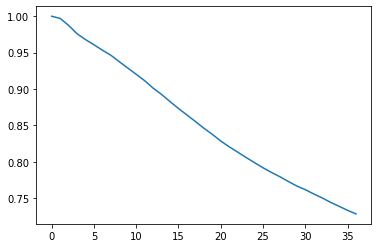

In [121]:
plt.plot(km_df['time'], km_df['prob_survival'])
plt.show()

In [135]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [127]:
data_1 = data_km_pred[data_km_pred['tertile'] == 1]
data_2 = data_km_pred[data_km_pred['tertile'] == 2]
data_3 = data_km_pred[data_km_pred['tertile'] == 3]

In [131]:
km_1 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
n_patients = data_1.shape[0]
prob_survival = 1
for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data_1[(data_1['months'] == t) & (data_1['PUF_VITAL_STATUS'] == 1)].shape[0]
    #count the number of patients who died
    n_died = data_1[(data_1['months'] == t) & (data_1['PUF_VITAL_STATUS'] == 0)].shape[0]
    #calculate the percent of patients who died at time t, and subtract that from the probability of survival
    perc_died = n_died / n_patients
    prob_survival = prob_survival - perc_died
    km_1 = km_1.append({'time': t, 'n_patients': n_patients, 'n_died': n_died, 'prob_survival': prob_survival}, ignore_index=True)
    #update the number of patients by removing the number of patients who died
    n_patients = n_patients - n_died
km_1.head()

,time,n_patients,n_died,prob_survival
0,0.0,11264.0,0.0,1.000000
1,1.0,11264.0,0.0,1.000000
2,2.0,11264.0,1.0,0.999911
3,3.0,11263.0,3.0,0.999645
4,4.0,11260.0,0.0,0.999645


In [132]:
km_2 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
n_patients = data_2.shape[0]
prob_survival = 1
for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data_2[(data_2['months'] == t) & (data_2['PUF_VITAL_STATUS'] == 1)].shape[0]
    #count the number of patients who died
    n_died = data_2[(data_2['months'] == t) & (data_2['PUF_VITAL_STATUS'] == 0)].shape[0]
    #calculate the percent of patients who died at time t, and subtract that from the probability of survival
    perc_died = n_died / n_patients
    prob_survival = prob_survival - perc_died
    km_2 = km_2.append({'time': t, 'n_patients': n_patients, 'n_died': n_died, 'prob_survival': prob_survival}, ignore_index=True)
    #update the number of patients by removing the number of patients who died
    n_patients = n_patients - n_died
km_2.head()

,time,n_patients,n_died,prob_survival
0,0.0,11262.0,0.0,1.000000
1,1.0,11262.0,10.0,0.999112
2,2.0,11252.0,37.0,0.995824
3,3.0,11215.0,39.0,0.992346
4,4.0,11176.0,29.0,0.989751


In [133]:
km_3 = pd.DataFrame(columns=['time', 'n_patients', 'n_died', 'prob_survival'])
n_patients = data_3.shape[0]
prob_survival = 1
for t in time_thresh:
    #censor patients who are alive, but lost to follow up
    n_patients = n_patients - data_3[(data_3['months'] == t) & (data_3['PUF_VITAL_STATUS'] == 1)].shape[0]
    #count the number of patients who died
    n_died = data_3[(data_3['months'] == t) & (data_3['PUF_VITAL_STATUS'] == 0)].shape[0]
    #calculate the percent of patients who died at time t, and subtract that from the probability of survival
    perc_died = n_died / n_patients
    prob_survival = prob_survival - perc_died
    km_3 = km_3.append({'time': t, 'n_patients': n_patients, 'n_died': n_died, 'prob_survival': prob_survival}, ignore_index=True)
    #update the number of patients by removing the number of patients who died
    n_patients = n_patients - n_died
km_3.head()

,time,n_patients,n_died,prob_survival
0,0.0,11264.0,3.0,0.999734
1,1.0,11261.0,90.0,0.991741
2,2.0,11171.0,284.0,0.966319
3,3.0,10887.0,340.0,0.935089
4,4.0,10547.0,237.0,0.912618


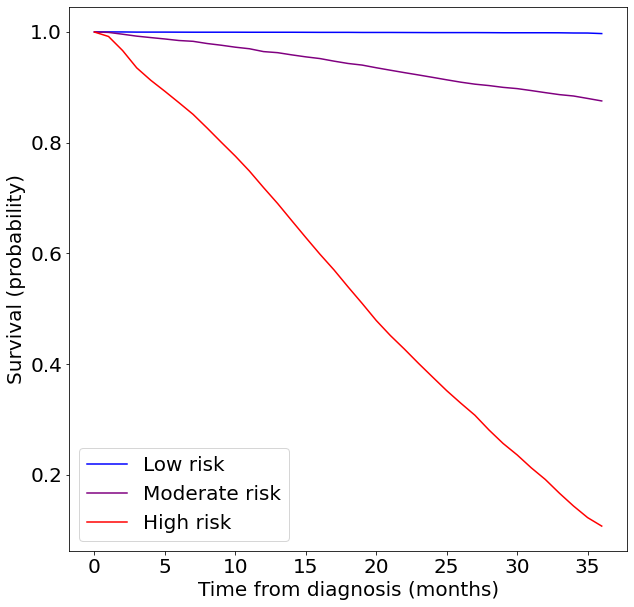

In [152]:
#plot the survival curves for the three tertiles on the same plot
# plt.plot(km_df['time'], km_df['prob_survival'], label='All Patients')
plt.figure(figsize=(10,10))
plt.plot(km_1['time'], km_1['prob_survival'], label='Low risk', color='blue')
plt.plot(km_2['time'], km_2['prob_survival'], label='Moderate risk', color='purple')
plt.plot(km_3['time'], km_3['prob_survival'], label='High risk', color='red')
plt.xlabel('Time from diagnosis (months)')
plt.ylabel('Survival (probability)')
plt.legend()
plt.rcParams.update({'font.size': 20})
plt.savefig('results/os/km.png', dpi=300, bbox_inches='tight')

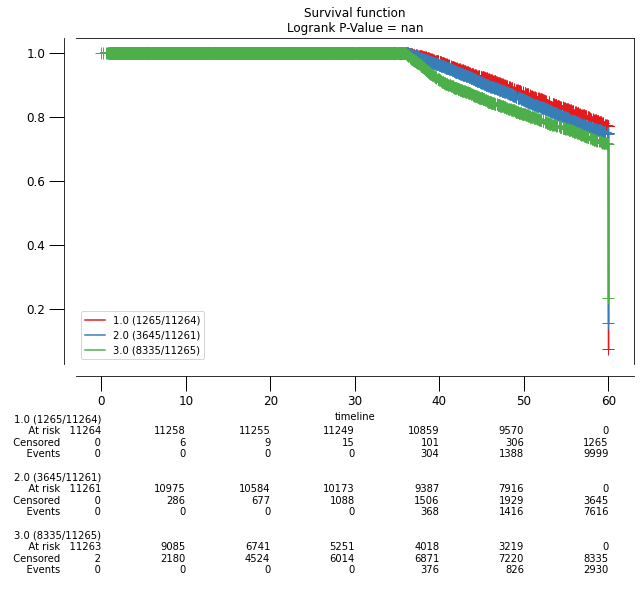

In [25]:
import kaplanmeier as km
time_event = data_km_pred['DX_LASTCONTACT_DEATH_MONTHS']
censoring = data_km_pred['PUF_VITAL_STATUS']
y = data_km_pred['tertile']

results = km.fit(time_event, censoring, y)
km.plot(results)

In [13]:
times = np.arange(0, 37, 1)

In [14]:
count_alive_1 = {}
for t in times:
    for i, row in data_1.iterrows():
        if row['DX_LASTCONTACT_DEATH_MONTHS'] >= t:
            if t in count_alive_1:
                count_alive_1[t] += 1
            else:
                count_alive_1[t] = 1
        else:
            if t in count_alive_1:
                count_alive_1[t] += 0
            else:
                count_alive_1[t] = 0
#convert to a dataframe
count_alive_1 = pd.DataFrame.from_dict(count_alive_1, orient='index')

count_alive_1.columns = ['count_alive']


In [15]:

count_alive_2 = {}
for t in times:
    for i, row in data_2.iterrows():
        if row['DX_LASTCONTACT_DEATH_MONTHS'] >= t:
            if t in count_alive_2:
                count_alive_2[t] += 1
            else:
                count_alive_2[t] = 1
        else:
            if t in count_alive_2:
                count_alive_2[t] += 0
            else:
                count_alive_2[t] = 0
#convert to a dataframe
count_alive_2 = pd.DataFrame.from_dict(count_alive_2, orient='index')
count_alive_2.columns = ['count_alive']


In [16]:

count_alive_3 = {}
for t in times:
    for i, row in data_3.iterrows():
        if row['DX_LASTCONTACT_DEATH_MONTHS'] >= t:
            if t in count_alive_3:
                count_alive_3[t] += 1
            else:
                count_alive_3[t] = 1
        else:
            if t in count_alive_3:
                count_alive_3[t] += 0
            else:
                count_alive_3[t] = 0
#convert to a dataframe
count_alive_3 = pd.DataFrame.from_dict(count_alive_3, orient='index')
count_alive_3.columns = ['count_alive']

In [17]:
count_alive_1['perc_alive'] = count_alive_1['count_alive'] / data_1.shape[0]
count_alive_2['perc_alive'] = count_alive_2['count_alive'] / data_2.shape[0]
count_alive_3['perc_alive'] = count_alive_3['count_alive'] / data_3.shape[0]

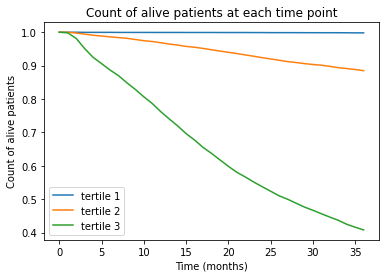

In [18]:
#plot all three survival curves on the same plot
plt.plot(count_alive_1.index, count_alive_1['perc_alive'], label='tertile 1')
plt.plot(count_alive_2.index, count_alive_2['perc_alive'], label='tertile 2')
plt.plot(count_alive_3.index, count_alive_3['perc_alive'], label='tertile 3')
plt.xlabel('Time (months)')
plt.ylabel('Count of alive patients')
plt.title('Count of alive patients at each time point')
plt.legend()
plt.show()